In [1]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]

/Users/mahim/opt/anaconda3/envs/workshop/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing...
Done!


In [45]:
dataset[0].train_mask

tensor([ True,  True,  True,  ..., False, False, False])

/var/folders/tt/7vqt9vpn5hgfqsch7s9xj4dr0000gn/T/ipykernel_5996/837559593.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


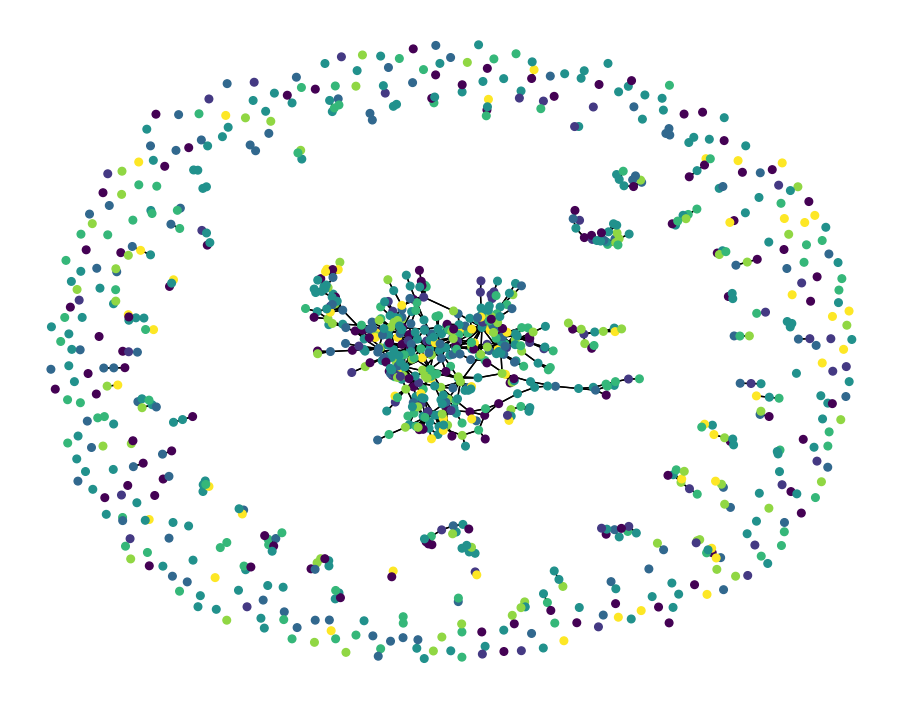

In [14]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import torch
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 
    
    
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

In [6]:
import torch_geometric.transforms as T

split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)

In [11]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

In [54]:
dataset.num_node_features

1433

In [15]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc
  
  
mlp = MLP().to('cpu')
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 0.906, Val Acc: 0.679
Epoch: 020, Train Loss: 0.110, Val Acc: 0.775
Epoch: 030, Train Loss: 0.021, Val Acc: 0.742
Epoch: 040, Train Loss: 0.014, Val Acc: 0.734
Epoch: 050, Train Loss: 0.012, Val Acc: 0.745
Epoch: 060, Train Loss: 0.009, Val Acc: 0.734
Epoch: 070, Train Loss: 0.008, Val Acc: 0.734
Epoch: 080, Train Loss: 0.007, Val Acc: 0.745
Epoch: 090, Train Loss: 0.007, Val Acc: 0.745
Epoch: 100, Train Loss: 0.006, Val Acc: 0.745
Epoch: 110, Train Loss: 0.006, Val Acc: 0.742
Epoch: 120, Train Loss: 0.006, Val Acc: 0.734
Epoch: 130, Train Loss: 0.006, Val Acc: 0.734
Epoch: 140, Train Loss: 0.006, Val Acc: 0.734
Epoch: 150, Train Loss: 0.006, Val Acc: 0.738
Test Acc: 0.740


In [1]:
import pandas as pd
df = pd.read_csv("df_env.csv")

In [2]:
#drop rows from csv where all values are nan
df = df.dropna(how='all')
#normalize df
df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
#df.apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(2))
df_list = df.values.tolist()
df.describe()

,mean.Temperature_60,grad.Temperature_60,sd.Temperature_60,mean.Temperature_480,grad.Temperature_480,sd.Temperature_480,mean.Humidity_60,grad.Humidity_60,sd.Humidity_60,mean.Humidity_480,...,grad.Winvel_60,sd.Winvel_60,mean.Winvel_480,grad.Winvel_480,sd.Winvel_480,mean.Solar_60,grad.Solar_60,sd.Solar_60,mean.Solar_480,grad.Solar_480
count,3585.000000,3514.000000,3514.000000,3593.000000,3522.000000,3522.000000,3585.000000,3514.000000,3514.000000,3593.000000,...,3514.000000,3514.000000,3593.000000,3522.000000,3522.000000,3585.000000,3514.000000,3514.000000,3593.000000,3522.000000
mean,0.396657,0.508178,0.123727,0.393652,0.505778,0.095873,0.706611,0.670580,0.062016,0.707549,...,0.558647,0.227130,0.188029,0.558634,0.315577,0.293081,0.502844,0.099607,0.285923,0.502459
std,0.149664,0.102693,0.100149,0.148805,0.098528,0.103211,0.188942,0.041688,0.056725,0.188610,...,0.060359,0.116609,0.128600,0.059378,0.158300,0.330858,0.033395,0.147532,0.328272,0.032315
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.292073,0.454545,0.052227,0.289852,0.454545,0.035158,0.570128,0.651965,0.028679,0.572595,...,0.540420,0.153096,0.091540,0.543701,0.212206,0.000000,0.494924,0.000868,0.001422,0.495564
50%,0.372797,0.505051,0.099695,0.370231,0.505051,0.064746,0.733607,0.671141,0.050033,0.734582,...,0.560000,0.212798,0.169903,0.560000,0.299552,0.136182,0.503876,0.043702,0.128613,0.503876
75%,0.468968,0.569330,0.165817,0.464578,0.561366,0.121020,0.860352,0.689545,0.078731,0.861566,...,0.578807,0.289550,0.257282,0.574654,0.404471,0.581255,0.508707,0.120596,0.563718,0.507939
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
import numpy as np
import torch
num_cols = 23
# only take [Age	Height	Weight	ColdSens	ColdExp] these columns for all rows
#df.iloc[:, 2:6]
#convert df to list
df_list = df.values.tolist()
#convert dflist torch geometric data
from torch_geometric.data import Data
graphs = []
for sensor in df_list:
    adj_matrix = np.ones((num_cols, num_cols))
    edge_list = np.transpose(np.nonzero(np.triu(adj_matrix))).reshape(2, -1)
    g = Data(x=torch.tensor(np.array(sensor).reshape(-1, 1), dtype=torch.float), edge_index=torch.tensor(edge_list,dtype=torch.long))
    g.y = torch.tensor(np.array(sensor).reshape(-1, 1), dtype=torch.float)
    g.train_mask = np.array([True]*num_cols)
    #print(np.argwhere(np.isnan(sensor)))
    g.train_mask[np.argwhere(np.isnan(sensor))] = False
    g.train_mask = torch.tensor(g.train_mask)

    g.test_mask = np.array(([False]*num_cols))
    g.test_mask[np.argwhere(np.isnan(sensor))] = True
    g.test_mask = torch.tensor(g.test_mask)
    graphs.append(g)

In [24]:
graphs[0].y

tensor([[0.6309],
        [0.7404],
        [0.4823],
        [0.4904],
        [0.5491],
        [0.5210],
        [0.3577],
        [0.6140],
        [0.1681],
        [0.5369],
        [0.7027],
        [0.3162],
        [0.1333],
        [0.5820],
        [0.2265],
        [0.1173],
        [0.5597],
        [0.4415],
        [0.6261],
        [0.5247],
        [0.1395],
        [0.1537],
        [0.5147]])

In [137]:
df.describe()

,mean.Temperature_60,grad.Temperature_60,sd.Temperature_60,mean.Temperature_480,grad.Temperature_480,sd.Temperature_480,mean.Humidity_60,grad.Humidity_60,sd.Humidity_60,mean.Humidity_480,...,grad.Winvel_60,sd.Winvel_60,mean.Winvel_480,grad.Winvel_480,sd.Winvel_480,mean.Solar_60,grad.Solar_60,sd.Solar_60,mean.Solar_480,grad.Solar_480
count,3585.000000,3.514000e+03,3514.000000,3593.000000,3.522000e+03,3522.000000,3585.000000,3514.000000,3514.000000,3593.000000,...,3514.000000,3514.000000,3593.000000,3522.000000,3522.000000,3585.000000,3514.000000,3514.000000,3593.000000,3522.000000
mean,14.466119,6.192828e-04,0.240862,14.433086,1.439515e-04,0.326475,72.154923,-0.001673,1.398359,72.240707,...,-0.000677,0.396502,1.291135,-0.000683,0.420623,293.227779,-0.133084,37.380384,286.065551,-0.182797
std,4.292368,2.033321e-02,0.194963,4.276472,1.950848e-02,0.351464,17.288169,0.124231,1.279042,17.257848,...,0.030179,0.203565,0.883054,0.029689,0.210993,331.023917,4.307959,55.365369,328.436458,4.168626
min,3.090000,-1.000000e-01,0.000000,3.120000,-1.000000e-01,0.000000,7.500000,-2.000000,0.000000,7.500000,...,-0.280000,0.000000,0.000000,-0.280000,0.000000,0.000000,-65.000000,0.000000,0.000000,-65.000000
25%,11.466667,-1.000000e-02,0.101672,11.450000,-1.000000e-02,0.119722,59.666667,-0.057143,0.646670,59.892473,...,-0.009790,0.267261,0.628571,-0.008149,0.282843,0.000000,-1.154818,0.325559,1.422535,-1.072273
50%,13.781818,8.965000e-17,0.194079,13.760000,-1.545000e-16,0.220479,74.625000,0.000000,1.128152,74.714286,...,0.000000,0.371484,1.166667,0.000000,0.399264,136.250000,0.000000,16.400573,128.677419,0.000000
75%,16.540000,1.272727e-02,0.322800,16.471429,1.115038e-02,0.412111,86.222222,0.054845,1.775251,86.333333,...,0.009404,0.505470,1.766667,0.007327,0.539108,581.545455,0.623255,45.256906,564.000000,0.524107
max,31.770000,9.800000e-02,1.946726,31.858824,9.800000e-02,3.405296,99.000000,0.980000,22.548239,99.000000,...,0.220000,1.745709,6.866667,0.220000,1.332871,1000.500000,64.000000,375.277675,1000.500000,64.000000


In [143]:
df.isnull().sum()

mean.Temperature_60      8
grad.Temperature_60     79
sd.Temperature_60       79
mean.Temperature_480     0
grad.Temperature_480    71
sd.Temperature_480      71
mean.Humidity_60         8
grad.Humidity_60        79
sd.Humidity_60          79
mean.Humidity_480        0
grad.Humidity_480       71
sd.Humidity_480         71
mean.Winvel_60           8
grad.Winvel_60          79
sd.Winvel_60            79
mean.Winvel_480          0
grad.Winvel_480         71
sd.Winvel_480           71
mean.Solar_60            8
grad.Solar_60           79
sd.Solar_60             79
mean.Solar_480           0
grad.Solar_480          71
dtype: int64

In [117]:
import math
for idx, l in enumerate(df_list):
    #if l contain a nan value
    if any(math.isnan(x) for x in l):
        print(idx, l)

4 [26.2, nan, nan, 26.2, nan, nan, 29.0, nan, nan, 29.0, nan, nan, 1.8, nan, nan, 1.8, nan, nan, 933.0, nan, nan, 933.0, nan]
6 [27.5, nan, nan, 27.5, nan, nan, 27.0, nan, nan, 27.0, nan, nan, 0.9, nan, nan, 0.9, nan, nan, 957.0, nan, nan, 957.0, nan]
99 [16.2, nan, nan, 16.2, nan, nan, 73.0, nan, nan, 73.0, nan, nan, 1.3, nan, nan, 1.3, nan, nan, 923.0, nan, nan, 923.0, nan]
123 [11.4, nan, nan, 11.4, nan, nan, 65.0, nan, nan, 65.0, nan, nan, 2.7, nan, nan, 2.7, nan, nan, 609.0, nan, nan, 609.0, nan]
323 [14.0, nan, nan, 14.0, nan, nan, 52.0, nan, nan, 52.0, nan, nan, 1.8, nan, nan, 1.8, nan, nan, 886.0, nan, nan, 886.0, nan]
358 [11.8, nan, nan, 11.8, nan, nan, 78.0, nan, nan, 78.0, nan, nan, 0.9, nan, nan, 0.9, nan, nan, 699.0, nan, nan, 699.0, nan]
433 [20.6, nan, nan, 20.6, nan, nan, 50.0, nan, nan, 50.0, nan, nan, 0.9, nan, nan, 0.9, nan, nan, 112.0, nan, nan, 112.0, nan]
436 [17.8, nan, nan, 17.8, nan, nan, 61.0, nan, nan, 61.0, nan, nan, 0.0, nan, nan, 0.0, nan, nan, 6.0, nan, 

In [119]:
#count nan values for all columns
df.isnull().sum()

mean.Temperature_60      8
grad.Temperature_60     79
sd.Temperature_60       79
mean.Temperature_480     0
grad.Temperature_480    71
sd.Temperature_480      71
mean.Humidity_60         8
grad.Humidity_60        79
sd.Humidity_60          79
mean.Humidity_480        0
grad.Humidity_480       71
sd.Humidity_480         71
mean.Winvel_60           8
grad.Winvel_60          79
sd.Winvel_60            79
mean.Winvel_480          0
grad.Winvel_480         71
sd.Winvel_480           71
mean.Solar_60            8
grad.Solar_60           79
sd.Solar_60             79
mean.Solar_480           0
grad.Solar_480          71
dtype: int64

In [122]:
#get the nan indexes from a list using numpy
import numpy as np
a = np.array([True]*23)

nan_indexes = np.argwhere(np.isnan(df_list[4]))
a[nan_indexes] = False
print(a)

[ True False False  True False False  True False False  True False False
  True False False  True False False  True False False  True False]


In [8]:
graphs[0]

Data(x=[23, 1], edge_index=[2, 276], y=[23, 1], train_mask=[23], test_mask=[23])

In [9]:
# check nulls rows in a pandas dataframe
df.isnull().sum(axis=0)

mean.Temperature_60      8
grad.Temperature_60     79
sd.Temperature_60       79
mean.Temperature_480     0
grad.Temperature_480    71
sd.Temperature_480      71
mean.Humidity_60         8
grad.Humidity_60        79
sd.Humidity_60          79
mean.Humidity_480        0
grad.Humidity_480       71
sd.Humidity_480         71
mean.Winvel_60           8
grad.Winvel_60          79
sd.Winvel_60            79
mean.Winvel_480          0
grad.Winvel_480         71
sd.Winvel_480           71
mean.Solar_60            8
grad.Solar_60           79
sd.Solar_60             79
mean.Solar_480           0
grad.Solar_480          71
dtype: int64

In [21]:
import torch.nn as nn

from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

In [27]:
from tqdm import tqdm
import math
def train_node_classifier(model, graphs, optimizer, criterion, n_epochs=2):

    for epoch in tqdm(range(1, n_epochs + 1)):
        total_loss = 0

        for graph in tqdm(graphs):
            model.train()
            optimizer.zero_grad()
            out = model(graph)
            loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
            
            if math.isnan(loss.item()):
                print(epoch, out[graph.train_mask], graph.y[graph.train_mask], criterion(out[graph.train_mask], graph.y[graph.train_mask]))
                break
                #print(loss)
                #print(graph.x, graph.train_mask)
               #break
            total_loss+=loss.item()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch: {epoch:03d}, Train Loss: {total_loss:.3f}')

    return model


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc
  
  
gcn = GCN().to('cpu')
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
mlp = train_node_classifier(gcn, graphs, optimizer_mlp, criterion)

  0%|          | 4/3593 [00:00<00:26, 136.31it/s]


1 tensor([[0.0418],
        [0.0417],
        [0.0657],
        [   nan],
        [   nan],
        [   nan],
        [   nan],
        [   nan]], grad_fn=<IndexBackward0>) tensor([[0.8058],
        [0.8031],
        [0.2350],
        [0.2350],
        [0.2621],
        [0.2621],
        [0.9325],
        [0.9325]]) tensor(nan, grad_fn=<MseLossBackward0>)
Epoch: 001, Train Loss: 0.778


100%|██████████| 2/2 [00:00<00:00, 23.94it/s]

2 tensor([[0.0418],
        [0.0417],
        [0.0657],
        [   nan],
        [   nan],
        [   nan],
        [   nan],
        [   nan]], grad_fn=<IndexBackward0>) tensor([[0.8058],
        [0.8031],
        [0.2350],
        [0.2350],
        [0.2621],
        [0.2621],
        [0.9325],
        [0.9325]]) tensor(nan, grad_fn=<MseLossBackward0>)
Epoch: 002, Train Loss: 0.778


In [31]:
import numpy as np

# number of nodes in the graph
num_nodes = 3

# create a matrix of all ones with dimensions num_nodes x num_nodes
adj_matrix = np.ones((num_nodes, num_nodes))

# set the diagonal elements to zero (since there are no self-loops)
#np.fill_diagonal(adj_matrix, 0)

# create the edge list by flattening the upper triangular portion of the matrix
edge_list = np.transpose(np.nonzero(np.triu(adj_matrix))).reshape(2, -1)

print(edge_list)


[[0 0 0 1 0 2]
 [1 1 1 2 2 2]]


In [28]:
np.triu(adj_matrix)

array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [27]:
np.nonzero(np.triu(adj_matrix))

(array([0, 0, 1]), array([1, 2, 2]))

In [33]:
torch.tensor(edge_list)

tensor([[0, 0, 0, 1, 0, 2],
        [1, 1, 1, 2, 2, 2]])

In [ ]:
#create train mask for pytorch geometric
train_mask = torch.zeros(num_nodes, dtype=torch.uint8)
